In [1]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import warnings

warnings.filterwarnings("ignore")

data = pd.read_csv('Company_Data.csv')

data = data.dropna()

numerical_features = ['CompPrice', 'Income', 'Advertising', 'Population', 'Price', 'Age', 'Education']

categorical_columns = ['ShelveLoc', 'Urban', 'US']

In [2]:
# Converting the target (Sales) variable into a categorical variable
#sales_threshold = 8
#data['Sales'] = data['Sales'].apply(lambda x: 'High' if x > sales_threshold else 'Low')

# Convert 'Sales' to a categorical variable
data['Sales'] = pd.cut(data['Sales'], bins=[-float('inf'), 5, 10, float('inf')], labels=['Low', 'Medium', 'High'])

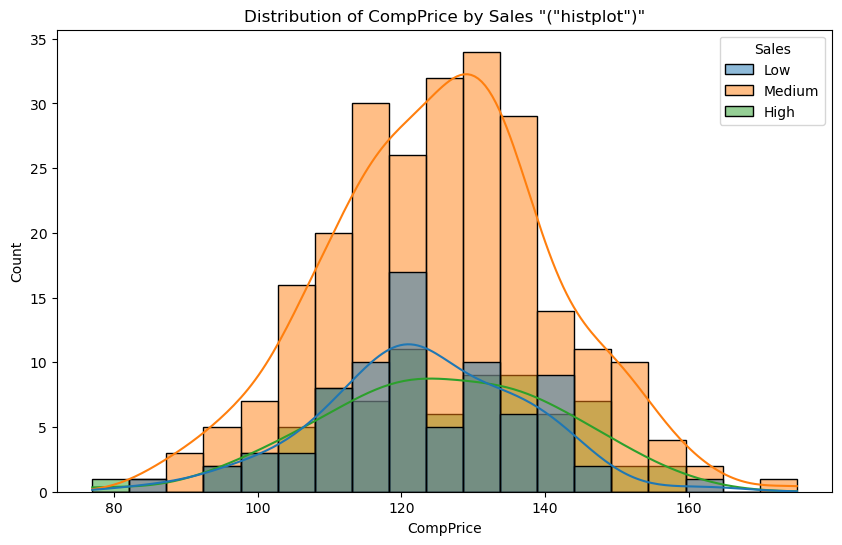

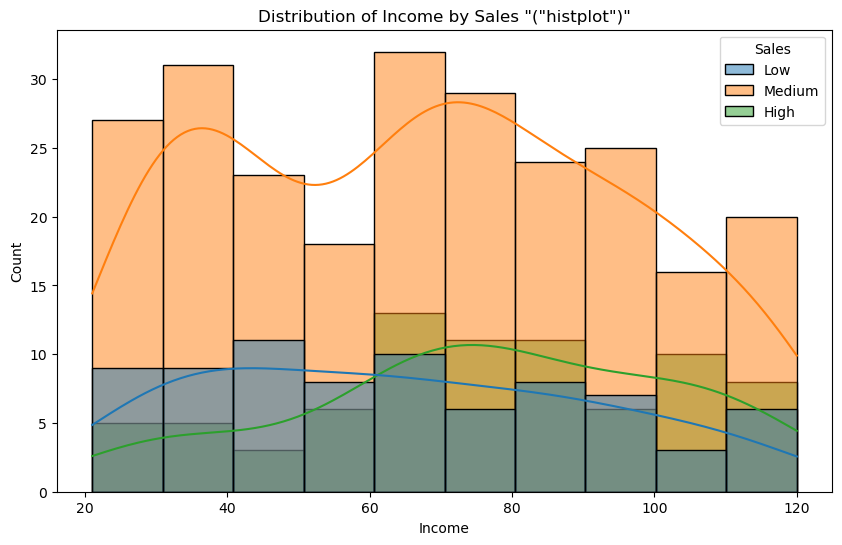

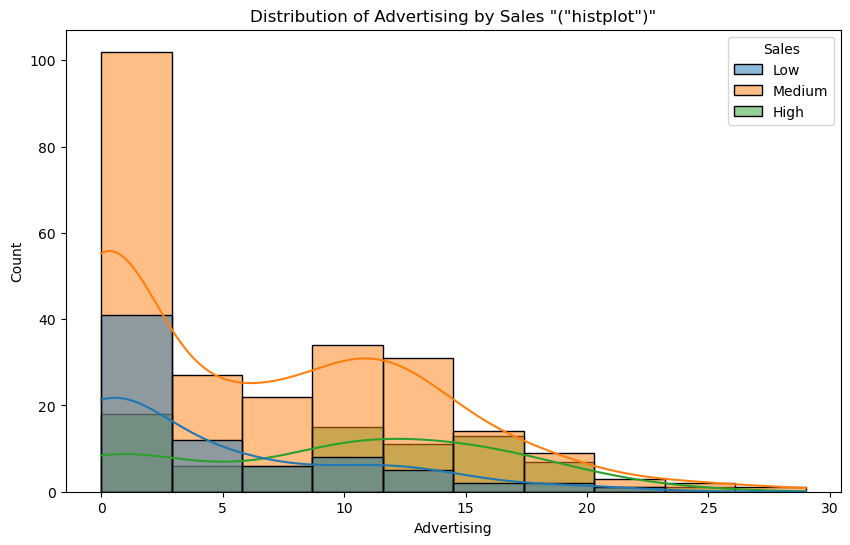

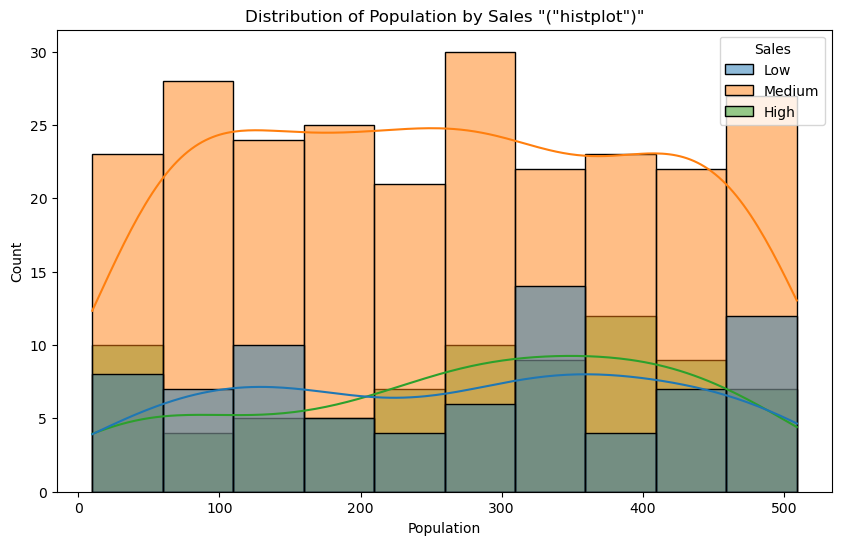

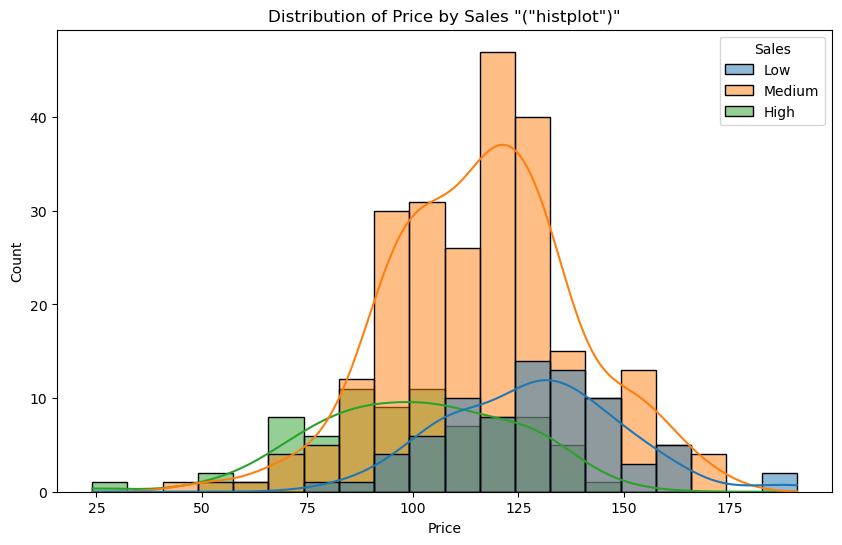

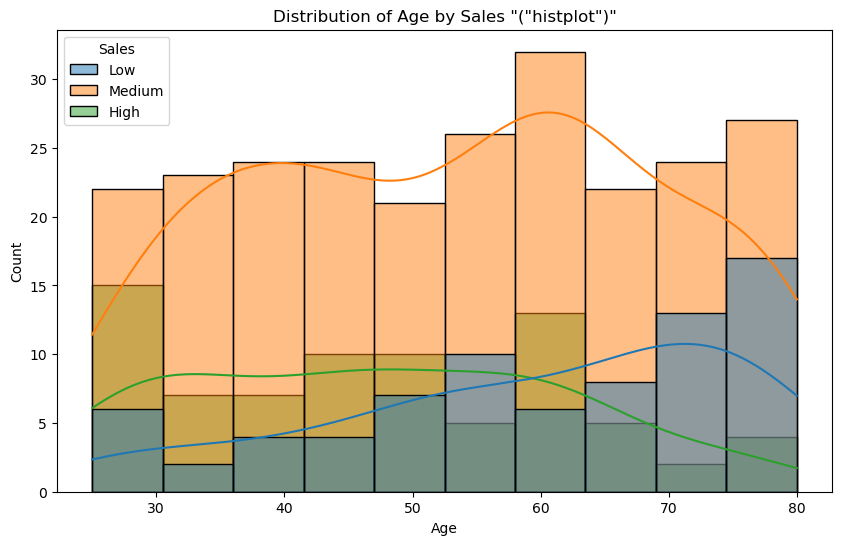

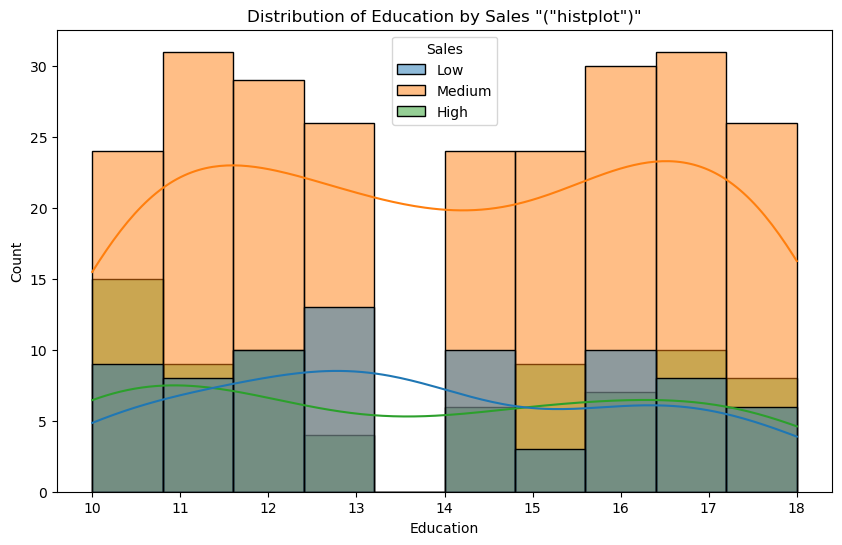

In [3]:
for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=data, x=feature, hue='Sales', kde=True)
    plt.title(f'Distribution of {feature} by Sales "("histplot")"')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.show()

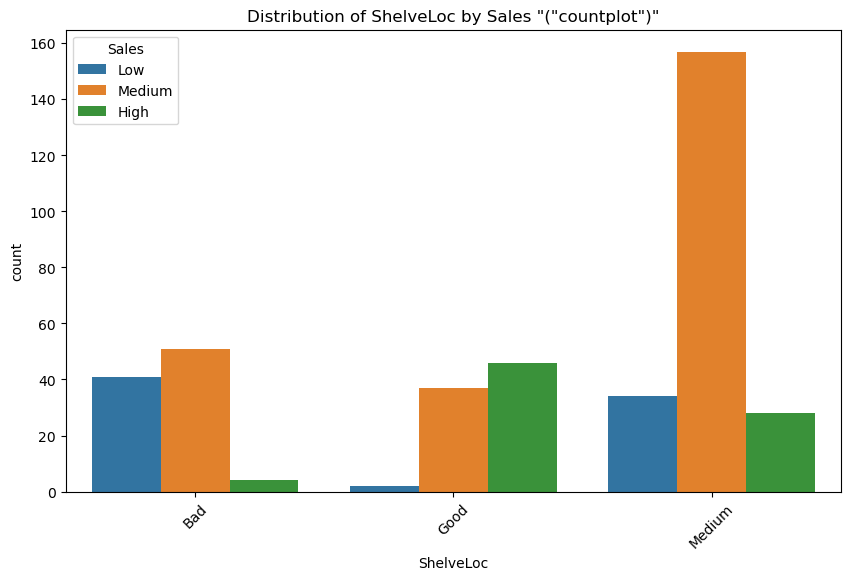

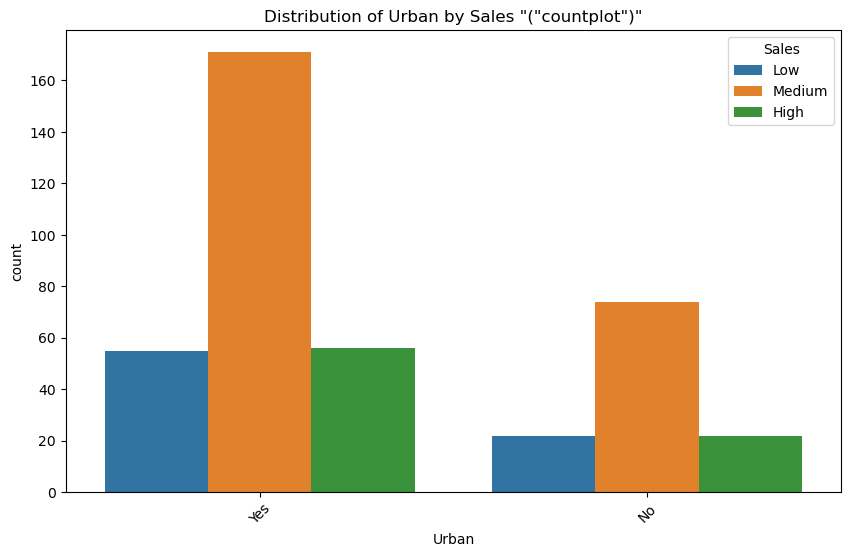

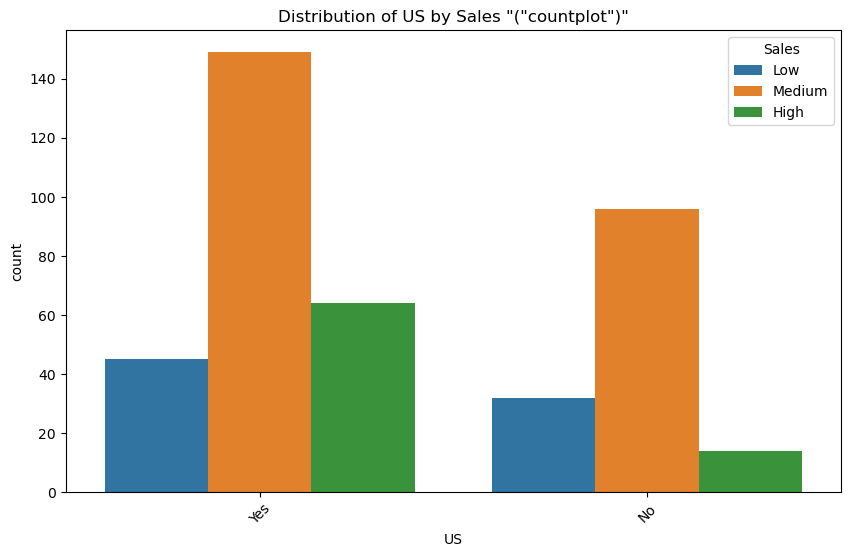

In [4]:
# Count Plots
for feature in categorical_columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=feature, hue='Sales', data=data)
    plt.title(f'Distribution of {feature} by Sales "("countplot")"')
    plt.xticks(rotation=45)
    plt.show()

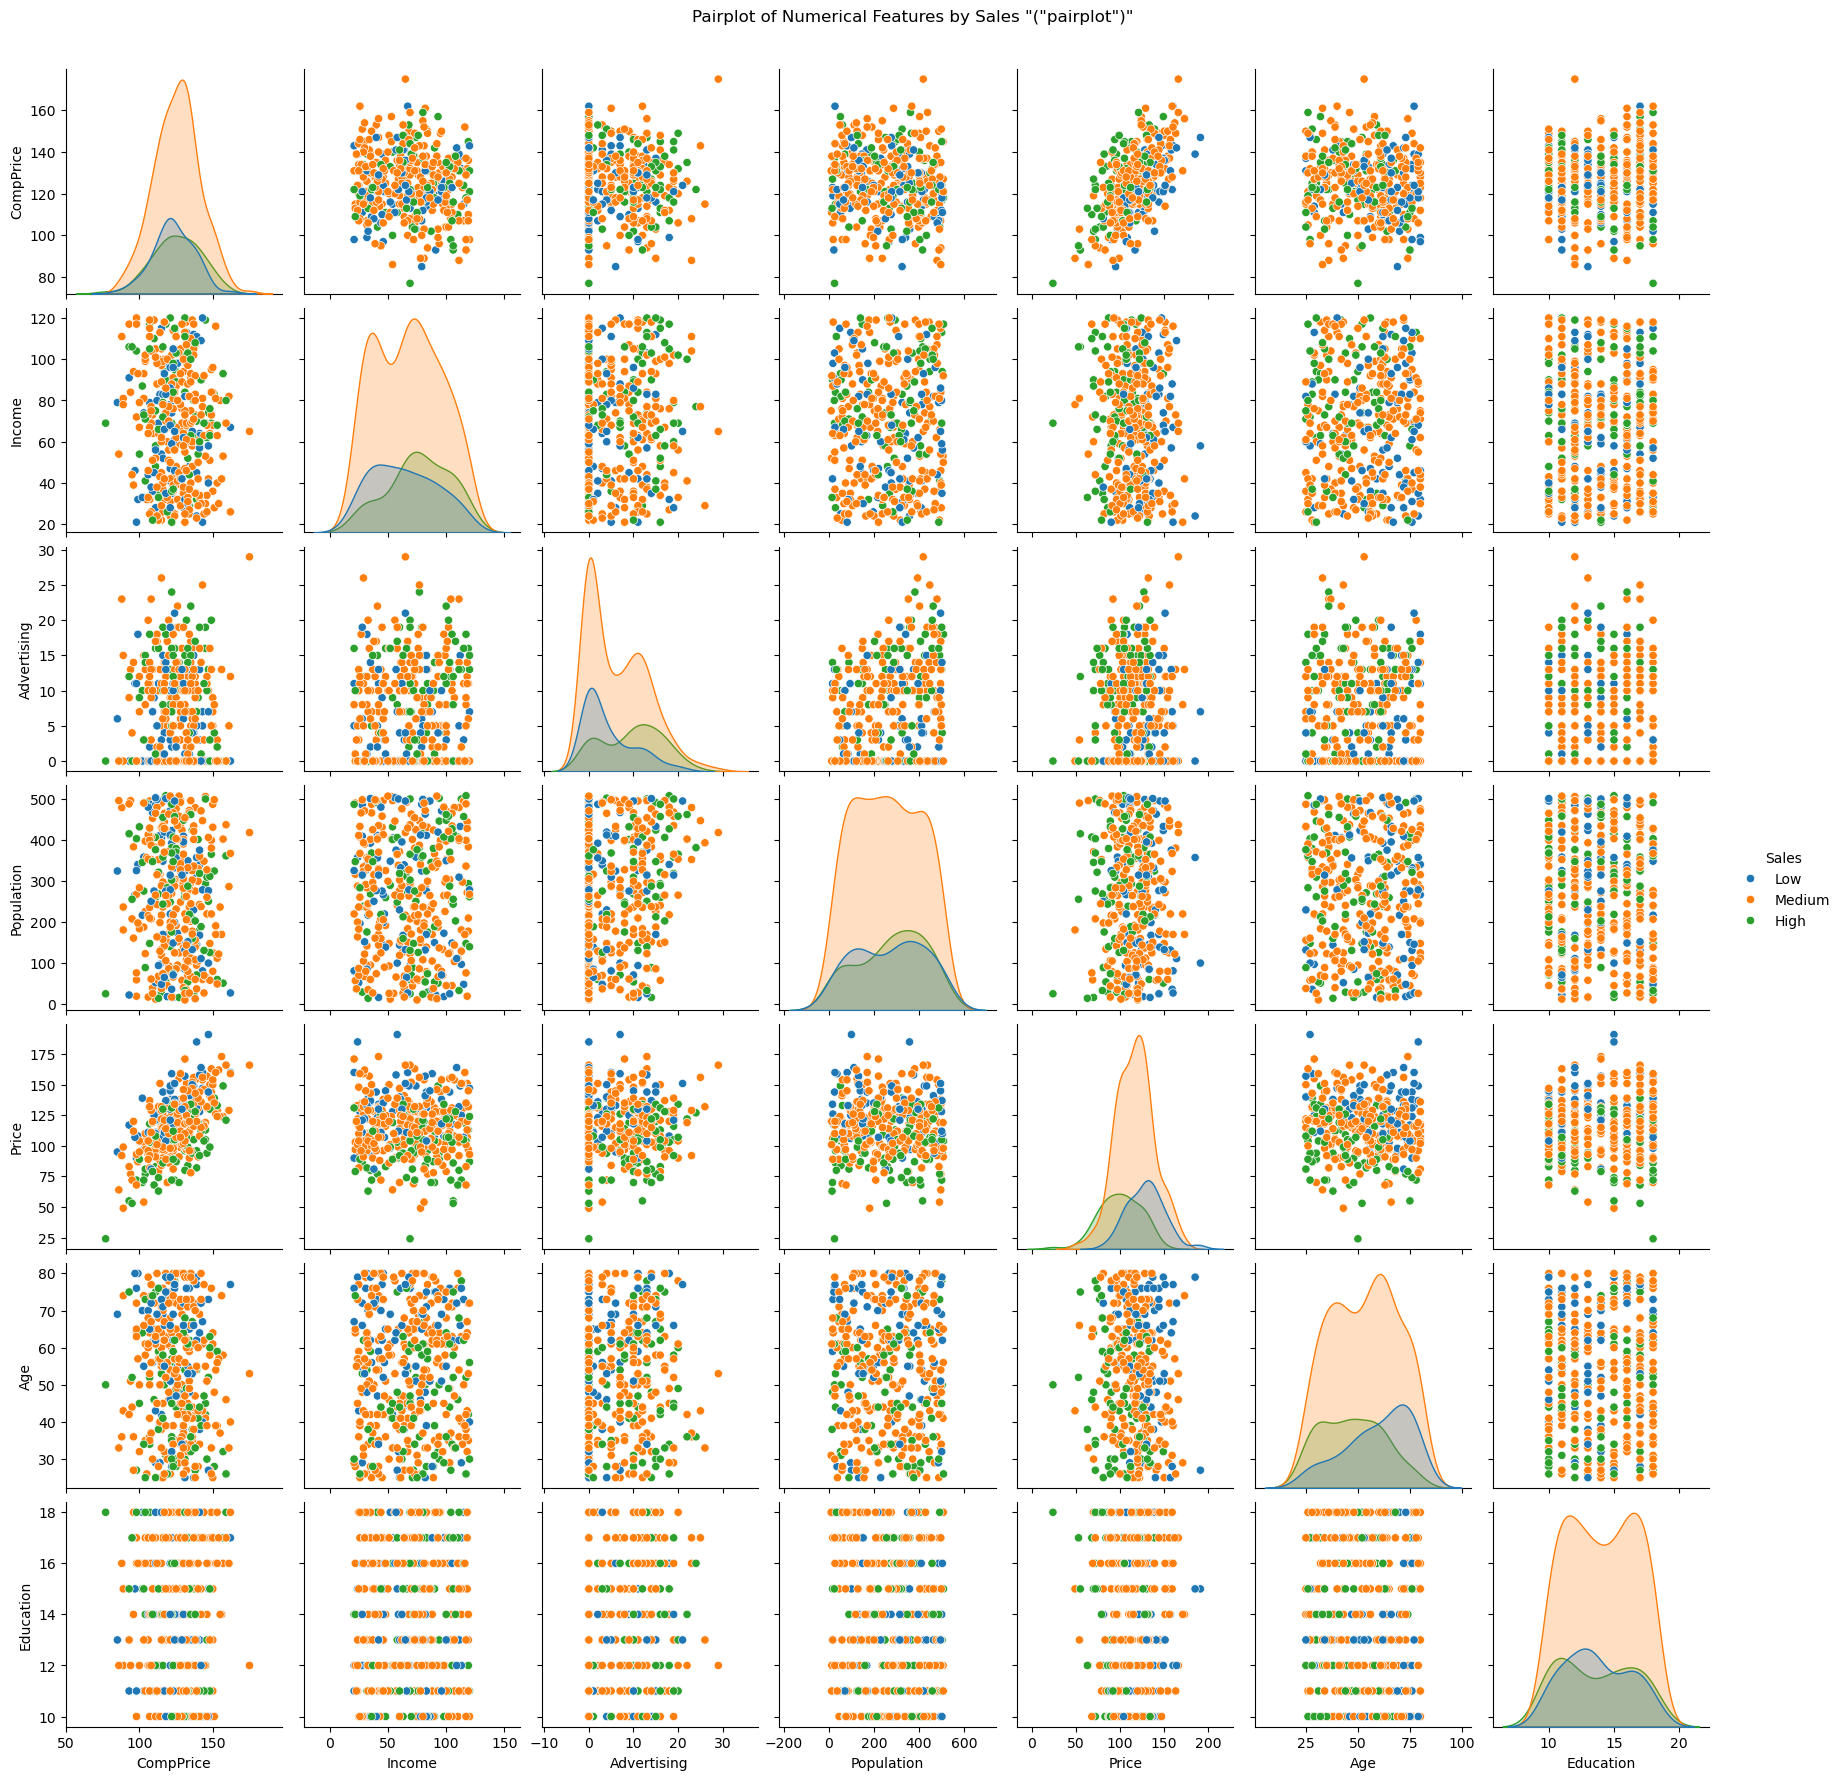

In [5]:
# Pairplot
sns.pairplot(data, hue='Sales', diag_kind='kde')
plt.suptitle('Pairplot of Numerical Features by Sales "("pairplot")"', y=1.02)
plt.show()

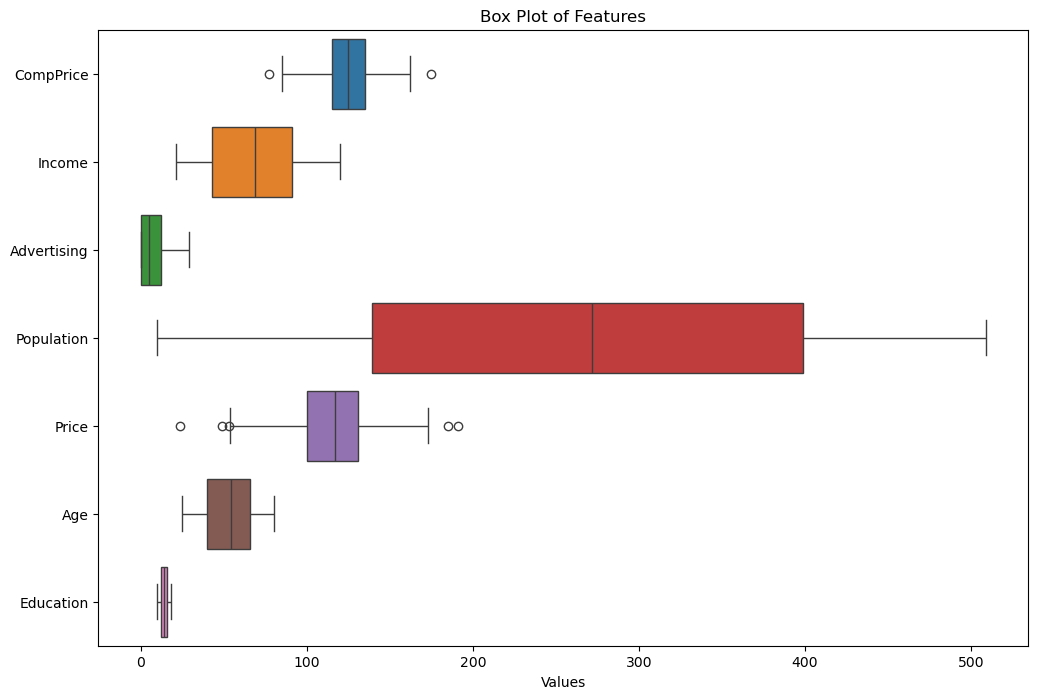

In [6]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=data, orient="h")
plt.title('Box Plot of Features')
plt.xlabel('Values')
plt.show()

In [7]:
def remove_outliers_iqr(df, features):
    for feature in features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]
    return df

# Remove outliers from combined_data
data = remove_outliers_iqr(data, numerical_features)

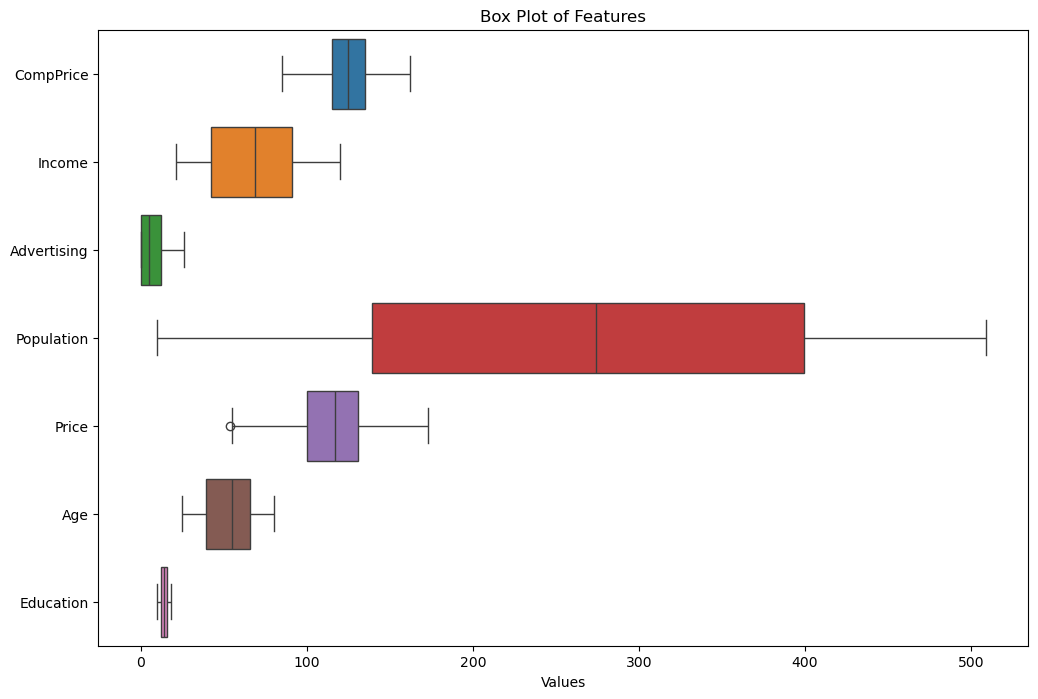

In [8]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=data, orient="h")
plt.title('Box Plot of Features')
plt.xlabel('Values')
plt.show()

In [9]:
# Data Pre-processing

# Convert categorical variables to numerical using Label Encoding
label_encoder = LabelEncoder()
data['ShelveLoc'] = data['ShelveLoc'].replace({'Good': 3, 'Medium': 2, 'Bad': 1})
data['Urban'] = label_encoder.fit_transform(data['Urban'])
data['US'] = data['US'].replace({'Yes': 1, 'No': 0})

In [10]:
unique_counts_shelve_loc = data['ShelveLoc'].value_counts()
unique_counts_urban = data['Urban'].value_counts()
unique_counts_us = data['US'].value_counts()

print("Unique counts for 'ShelveLoc':")
print(unique_counts_shelve_loc)

print("\nUnique counts for 'Urban':")
print(unique_counts_urban)

print("\nUnique counts for 'US':")
print(unique_counts_us)

Unique counts for 'ShelveLoc':
ShelveLoc
2    215
1     95
3     84
Name: count, dtype: int64

Unique counts for 'Urban':
Urban
1    278
0    116
Name: count, dtype: int64

Unique counts for 'US':
US
1    256
0    138
Name: count, dtype: int64


In [11]:
# Separate features (independent variables) and target variable
X = data.drop('Sales', axis=1)
y = data['Sales']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [12]:
# Oversampling with SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [13]:
unique_counts_us = y_train.value_counts()
print("\nUnique counts for 'Sales':")
print(unique_counts_us)


Unique counts for 'Sales':
Sales
Low       194
Medium    194
High      194
Name: count, dtype: int64


In [14]:
# Define the parameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

rf_model = RandomForestClassifier(random_state=42)

rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid, cv=5, scoring='accuracy')

# Fit the Random Forest model
rf_grid_search.fit(X_train, y_train)

# Get the best parameters and best score for Random Forest
best_params_rf = rf_grid_search.best_params_
best_score_rf = rf_grid_search.best_score_

print("Best Parameters for Random Forest:", best_params_rf)
print("Best Score for Random Forest:", best_score_rf)

best_rf_model = rf_grid_search.best_estimator_

# Make predictions on the test set for Random Forest
y_pred_rf = best_rf_model.predict(X_test)

# Calculate accuracy for Random Forest
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print("Accuracy for Random Forest:", accuracy_rf)

Best Parameters for Random Forest: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Score for Random Forest: 0.8746389625699971
Accuracy for Random Forest: 0.6455696202531646


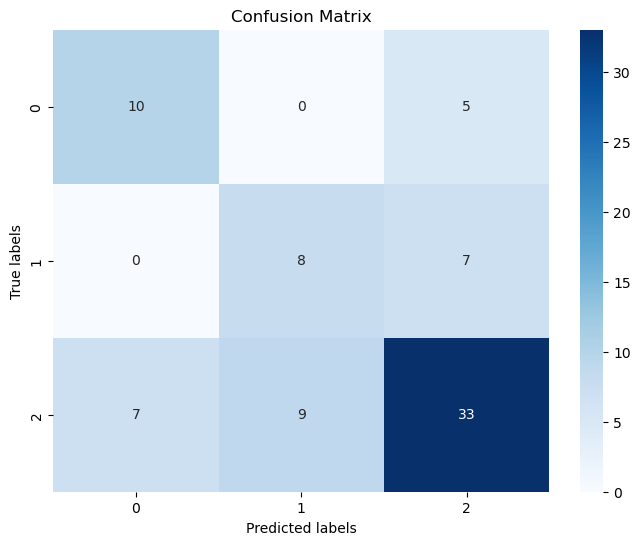

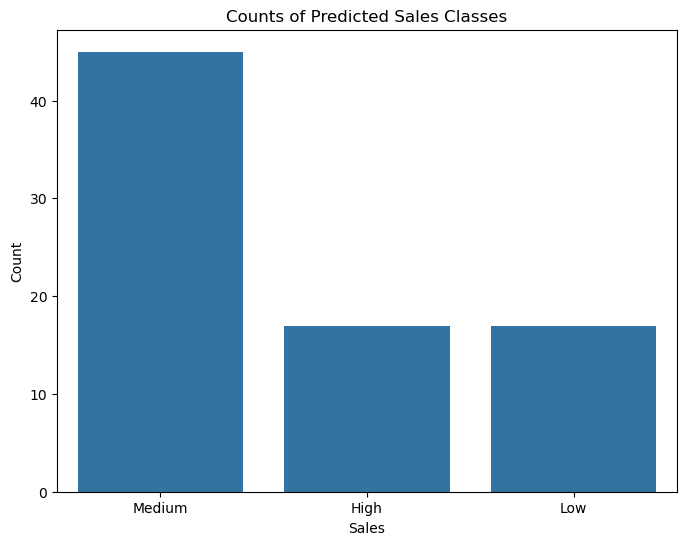

In [15]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Model Evaluation
# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Prediction Analysis
# Counts of Predicted Sales Classes
X_test['Predicted_Sales'] = y_pred_rf

plt.figure(figsize=(8, 6))
sns.countplot(x='Predicted_Sales', data=X_test)
plt.title('Counts of Predicted Sales Classes')
plt.xlabel('Sales')
plt.ylabel('Count')
plt.show()